In [1]:
import pandas as pd
import numpy as np

import os

from load_wastewater_data import *
from plotting_tools import *
import seaborn as sns

# Update rcParams to set the default font to Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Serif'

In [2]:
# define experiment to be preprocessed
experiment_series = "2024_09_17"

resolution = "3_min_resolution" 
rain_scenario = "KeinRegen" # one of KeinRegen, Nieselregen, MittelstarkerRegen
degradation_setting = "no_decay" # one of "no_decay", "linear_decay_dynamics", "constant_decay_dynamics"

In [3]:
plot_path = f"../plots/combined_plots"
os.makedirs(plot_path, exist_ok=True)
file_name_prefix = f"{resolution}_{rain_scenario}_{degradation_setting}"

In [4]:
df_conc = load_systems_data(experiment_series, resolution, rain_scenario, degradation_setting, file_type="concentrations")

In [5]:
infection_model_output_path = f"../../preprocessing/preprocessed_data/infection_model/{experiment_series}"
os.makedirs(os.path.join(infection_model_output_path), exist_ok=True)
os.makedirs(os.path.join(infection_model_output_path, "agent_trajectories"), exist_ok=True)
os.makedirs(os.path.join(infection_model_output_path, "infections_per_location"), exist_ok=True)

## Visualize & analyze results

In [6]:
# Define upstream locations for three sampling points of the neighbourhood
upstream_1 = ["00083", "00084", "00085"] # ++systems areas upstream of sampling point 1
upstream_2 = ["00102", "00103"] # ++systems areas upstream of sampling point 2
upstream_3 = upstream_1 + upstream_2 + ["00086", "00087"] # ++systems areas upstream of sampling point 3

upstream_locations_dict = {"1": upstream_1, "2": upstream_2, "3": upstream_3}

In [7]:
def viral_load(t, tau_E, tau_I_ns, tau_infected):
    peak_value = 8.1
    incline = peak_value / (tau_E + tau_I_ns) # peak value divided by sum of incubation and non-symptomatic infection period
    if tau_E + tau_I_ns == tau_infected:
        # non-symptomatic infection
        tau_peak = 0.5*tau_infected
        peak_value = incline * tau_peak
    else:
        tau_peak = tau_E + tau_I_ns
    decline = -peak_value / (tau_infected - tau_peak)
    if t < 0:
        return 0
    elif t <= tau_peak:
        return incline * t
    elif t <= tau_infected:
        return peak_value + decline*(t - tau_peak)
    else:
        return 0


def shedding(t, tau_E, tau_I_ns, tau_infected):
    c1 = -7
    c2 = 1
    shedding = 1/(1+np.exp(-(c1+c2*viral_load(t, tau_E, tau_I_ns, tau_infected))))
    return shedding


def infectiousness(t_since_transmission, tau_E, tau_I_ns, tau_infected):
    kappa = 10**(7.1) 

    if t_since_transmission < 0:
        return 0

    t_shift = tau_E*0.6

    t_s_end = tau_infected

    if t_shift <= t_since_transmission and t_since_transmission <= t_s_end:
        infectiousness = kappa * shedding((t_since_transmission - t_shift), tau_E, tau_I_ns, tau_infected)
    else:
        infectiousness = 0

    return infectiousness


In [8]:
def load_infection_path_information(simulation_id, experiment_series):
    """
    This function loads the infection path information from the MEmilio output and returns a tidied version of it.

    Parameters
    ----------
    simulation_id : int
        identifier of memilio simulation
    experiment_series : str
        name of the experiment series in which the simulation was run

    Returns
    -------
    pd.DataFrame
        with columns agent_id, t_exposed (time span of exposure), t_infected (time span of infection), hospitalized (whether or not the agent was hospitalized)
    """
    # read in infection paths
    infection_paths = pd.read_csv(f"../../simulation_output/infection_model/{experiment_series}/{simulation_id}_infection_paths.txt", header=0, index_col=None, sep=" ").reset_index()
    new_cols = infection_paths.columns[1:].to_list()
    new_cols.append("bla")
    infection_paths.columns = new_cols
    infection_paths = infection_paths.drop(columns="bla")

    # infection duration
    infection_paths["t_infected"] = infection_paths["E"] + infection_paths["I_ns"] + infection_paths["I_sy"] + infection_paths["I_sev"] + infection_paths["I_cri"]
    infection_paths["hospitalized"] = infection_paths["I_sev"] + infection_paths["I_cri"] > 0

    # For the shedding curve, we only need the agent id, duration of infection, the duration of exposure, and whether the agent was hospitalized
    infection_paths = infection_paths[["Agent_id", "E", "I_ns", "t_infected", "hospitalized"]]
    infection_paths.columns = ["agent_id", "t_exposed", "t_nonsymptomatic", "t_infected", "hospitalized"]
    
    # change time scale to days
    infection_paths[["t_exposed", "t_nonsymptomatic", "t_infected"]] = infection_paths[["t_exposed", "t_nonsymptomatic", "t_infected"]] / 24

    return infection_paths

#### Analysis for 1 simulation

In [9]:
sampling_point = "3"
simulation_id = 4

upstream_locations = upstream_locations_dict[sampling_point]

In [10]:
# load agent trajectory data
df_agent_trajectory = pd.read_csv(f"{infection_model_output_path}/agent_trajectories/agent_trajectories_{simulation_id}.csv", index_col=0)
df_agent_trajectory["systems_location"] = df_agent_trajectory["systems_location"].astype(str).apply(lambda x: x.zfill(5))
df_agent_trajectory["infected"] = df_agent_trajectory["time_since_transmission"] > 0

In [11]:
df_agent_trajectory = df_agent_trajectory.loc[df_agent_trajectory.systems_location.isin(upstream_locations), :]

# add infection path information
infection_path = load_infection_path_information(simulation_id, experiment_series)
df_agent_trajectory = df_agent_trajectory.merge(infection_path, on="agent_id")

# load concentration data
df_conc_sub = df_conc.loc[(df_conc.sampling_point==sampling_point) & (df_conc.memilio_id==simulation_id), :].copy()
df_conc_sub.sort_values("time_in_days", inplace=True)

In [12]:
upstream_locations

['00083', '00084', '00085', '00102', '00103', '00086', '00087']

In [13]:
df_agent_trajectory.head()

,systems_location,agent_id,time_in_hours,time_since_transmission,time_in_days,simulation_id,infected,t_exposed,t_nonsymptomatic,t_infected,hospitalized
0,00083,364.0,0.0,-0.041667,0.000000,4,False,0.0,0.0,0.0,False
1,00083,364.0,1.0,-0.041667,0.041667,4,False,0.0,0.0,0.0,False
2,00083,364.0,2.0,-0.041667,0.083333,4,False,0.0,0.0,0.0,False
3,00083,364.0,3.0,-0.041667,0.125000,4,False,0.0,0.0,0.0,False
4,00083,364.0,4.0,-0.041667,0.166667,4,False,0.0,0.0,0.0,False


In [14]:
df_agent_trajectory["t_exposed"] = df_agent_trajectory["t_exposed"].astype(float)
df_agent_trajectory["t_infected"] = df_agent_trajectory["t_infected"].astype(float)

# if transmission happened before simulation: set t_exposed to the first time since transmission and add it to total t_infected time
rel_rows = (df_agent_trajectory["time_since_transmission"]>0) & (df_agent_trajectory["t_exposed"]==0)
new_t_E = df_agent_trajectory.loc[rel_rows,:].groupby("agent_id")["time_since_transmission"].min().reset_index().rename(columns={"time_since_transmission": "t_exposed_new"})
new_t_E["t_exposed_new"] = new_t_E["t_exposed_new"]

df_agent_trajectory = df_agent_trajectory.merge(new_t_E, on="agent_id", how="left")

df_agent_trajectory.loc[rel_rows, "t_exposed"] = df_agent_trajectory.loc[rel_rows, "t_exposed_new"]
df_agent_trajectory.loc[rel_rows, "t_infected"] = df_agent_trajectory.loc[rel_rows, "t_exposed_new"] + df_agent_trajectory.loc[rel_rows, "t_infected"]

df_agent_trajectory.drop(columns="t_exposed_new", inplace=True)


# Add information about shedding
df_agent_trajectory["shedding"] = df_agent_trajectory.apply(lambda row: infectiousness(row["time_since_transmission"], row["t_exposed"], row["t_nonsymptomatic"], row["t_infected"]), axis=1)


In [15]:
# number of infected agents over time
upstream_prevalence = df_agent_trajectory.groupby("time_in_days").sum()["infected"].reset_index().rename(columns={"infected": "n_infections"})

# Average time since transmission for all infected agents
avg_times_since_transmission = df_agent_trajectory.loc[df_agent_trajectory.time_since_transmission>0, :].groupby("time_in_days")["time_since_transmission"].mean().reset_index()
# ensuring that each we also see missing values
all_times = df_agent_trajectory.time_in_days.sort_values().unique().tolist()
all_times_df = pd.DataFrame({"time_in_days": all_times})
avg_times_since_transmission = all_times_df.merge(avg_times_since_transmission, on=["time_in_days"], how="left")

# Average upstream shedding for all infected agents
total_shedding = df_agent_trajectory.groupby("time_in_days").sum()["shedding"].reset_index()

# Total number of agents located upstream over time
upstream_agents = df_agent_trajectory.groupby("time_in_days")["agent_id"].nunique().reset_index().rename(columns={"agent_id": "n_agents"})

In [16]:
def lineplot_breaknans(data, break_at_nan=True, break_at_inf=True, **kwargs):
    '''sns.lineplot by default doesn't break the line at nans or infs, 
        which can lead to misleading plots.
    See https://github.com/mwaskom/seaborn/issues/1552 
        and https://stackoverflow.com/questions/52098537/avoid-plotting-missing-values-on-a-line-plot
    
    This function rectifies this, and allows the user to specify 
        if it should break the line at nans, infs, or at both (default).
    
    Note: using this function means you can't use the `units` argument of sns.lineplot.'''

    cum_num_nans_infs = np.zeros(len(data))
    if break_at_nan: cum_num_nans_infs += np.cumsum(np.isnan(data[kwargs['y']]))
    if break_at_inf: cum_num_nans_infs += np.cumsum(np.isinf(data[kwargs['y']]))
    sns.lineplot(data, **kwargs, units=cum_num_nans_infs, 
            estimator=None)  #estimator must be None when specifying units

In [17]:
# Get information about shedding for each agent individually (agents that peak earlier should appear first in infected agents list)
infected_agent_ids = df_agent_trajectory.loc[df_agent_trajectory.shedding>0,:].sort_values(["time_in_days","shedding"])["agent_id"].unique()
stacked_shedding = df_agent_trajectory.loc[df_agent_trajectory.agent_id.isin(infected_agent_ids), ['agent_id', 'time_in_days', 'shedding']]

# stacked shedding
# ensuring that each we also see missing values
all_times = df_agent_trajectory.time_in_days.sort_values().unique().tolist()
all_times_df = pd.DataFrame({"time_in_days": all_times*len(infected_agent_ids), "agent_id": np.repeat(infected_agent_ids, len(all_times))})
stacked_shedding = all_times_df.merge(stacked_shedding, on=["time_in_days", "agent_id"], how="left")
stacked_shedding["shedding"] = stacked_shedding["shedding"].fillna(0)


In [18]:
stacked_shedding.sort_values("time_in_days", inplace=True)

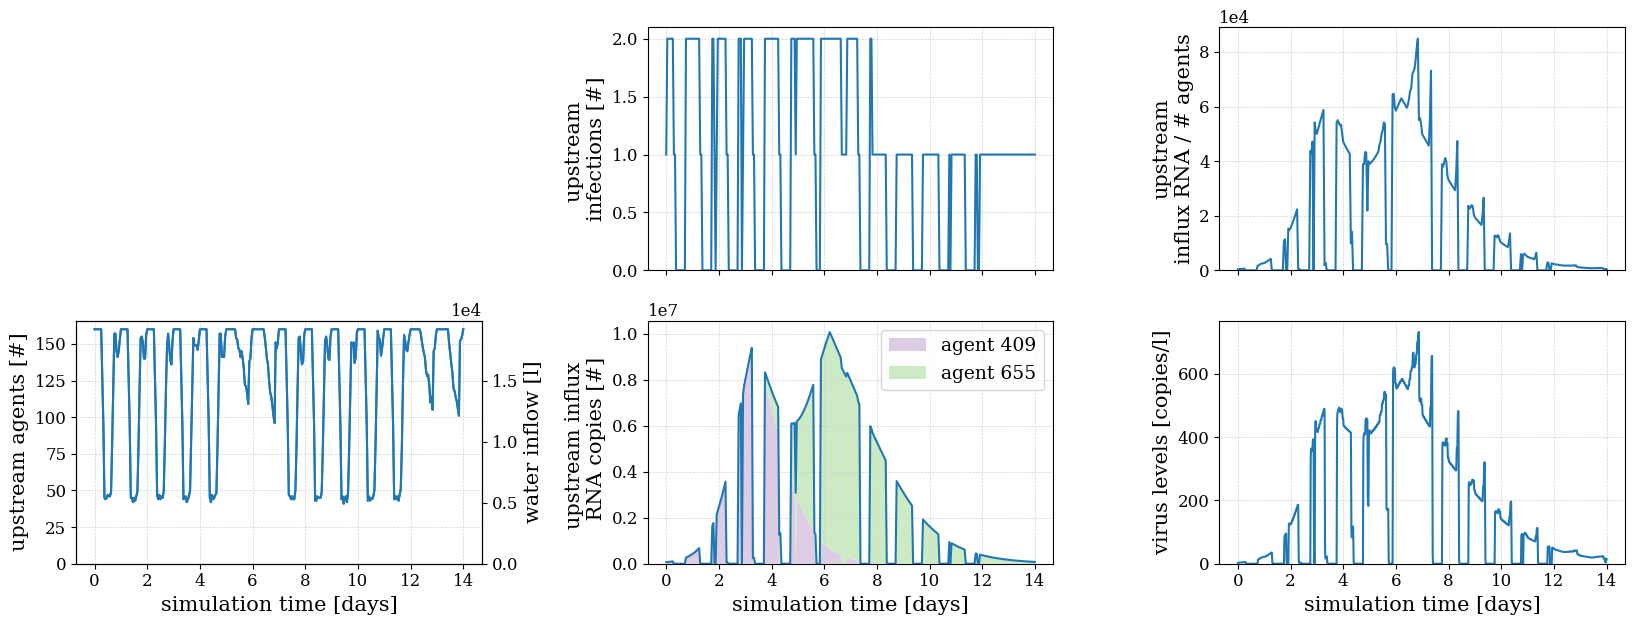

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(16.6, 6.5), sharex=True)

# prevalence (equals number of upstream infections here)
sns.lineplot(upstream_prevalence, x="time_in_days", y="n_infections", ax=axs[0,1])
axs[0,1].set_ylabel("upstream \ninfections [#]")

# time since transmission
#lineplot_breaknans(avg_times_since_transmission, x="time_in_days", y="time_since_transmission", ax=axs[0, 2], break_at_nan=True, break_at_inf=True)
#axs[0, 2].set_ylabel("avg. time since transmission \nfor infected agents [days]")

# upstream prevalence (%)
#upstream_agents["prevalence_fraction"] = upstream_prevalence["n_infections"]/upstream_agents["n_agents"]
#sns.lineplot(data=upstream_agents, x="time_in_days", y="prevalence_fraction", ax=axs[0,2])
#axs[0, 2].set_ylabel("upstream \nprevalence [fraction]")

# upstream influx RNA / n agents
total_shedding["shedding_per_agent"] = total_shedding["shedding"]/upstream_agents["n_agents"]
sns.lineplot(data=total_shedding, x="time_in_days", y="shedding_per_agent", ax=axs[0,2])
axs[0, 2].set_ylabel("upstream\ninflux RNA / # agents")
# axs[0, 2].ticklabel_format(axis="y", style="sci", scilimits=(4,4))

# upstream influx RNA per agent
x = stacked_shedding.time_in_days.unique()
y = [stacked_shedding.loc[stacked_shedding.agent_id==agent_id, "shedding"].values for agent_id in infected_agent_ids]
axs[1,1].stackplot(x,y, labels=[f"agent {int(i)}" for i in infected_agent_ids], colors=[sns.color_palette("Pastel1")[i] for i in [3,2, 6, 7, 8]])# sns.color_palette("Pastel1")) # [sns.color_palette("Pastel1")[i] for i in [0, 2, 3, 4, 5, 6, 7, 8]])
axs[1,1].legend(loc='upper right')

# upstream influx RNA
sns.lineplot(data=total_shedding, x="time_in_days", y="shedding", ax=axs[1,1])
axs[1,1].set_xlabel(f"simulation time [days]")
axs[1,1].set_ylabel("upstream influx \n RNA copies [#]")

# upstream agents
sns.lineplot(data=upstream_agents, x="time_in_days", y="n_agents", ax=axs[1,0])
axs[1,0].set_xlabel(f"simulation time [days]")
axs[1,0].set_ylabel("upstream agents [#]")
axs[1,0].set_ylim(0)
ax_1_0_right = axs[1,0].twinx()
# 120 l/d per agent 
upstream_agents["inflow"] = upstream_agents["n_agents"]*120
sns.lineplot(data = upstream_agents, x="time_in_days", y="inflow", ax=ax_1_0_right)
ax_1_0_right.set_ylabel("water inflow [l]")
ax_1_0_right.set_ylim(0)
# ax_1_0_right.ticklabel_format(axis="y", style="sci", scilimits=(4,4))

# concentration
sns.lineplot(data=df_conc_sub, x="time_in_days", y="COVID_copies/l", ax=axs[1,2])
axs[1,2].set_xlabel(f"simulation time [days]")
axs[1,2].set_ylabel("virus levels [copies/l]") #  for infected agents

# axs[1,0].set_visible(False)
for i in range(2):
    for j in range(3):
        axs[i,j].grid(color="lightgrey", linestyle="--", linewidth=0.5)
        axs[i,j].set_ylim(0.0)


axs[0,0].set_visible(False)

# fig.suptitle(f'Station {sampling_point}, Simulation {simulation_id}', fontsize=15)
plt.tight_layout()

plt.savefig(os.path.join(plot_path, file_name_prefix+f'_overview_station_{sampling_point}_simulation_{simulation_id}.png'))

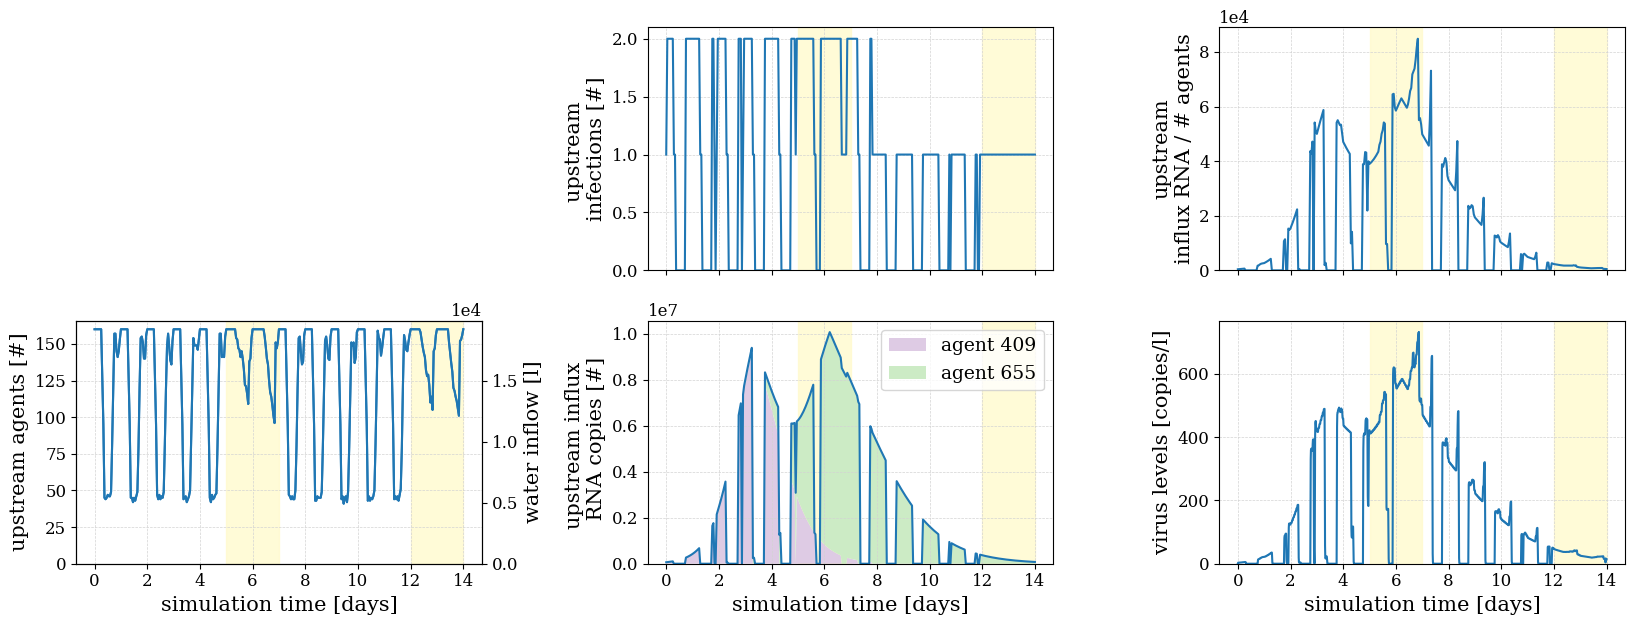

In [34]:
import matplotlib.patches as patches
import matplotlib.ticker as ticker

fig, axs = plt.subplots(2, 3, figsize=(16.6, 6.5), sharex=True)

# Function to add yellow background rectangle
def highlight_days(ax, start, end, color='lemonchiffon', alpha=0.3):
    ax.add_patch(patches.Rectangle((start, ax.get_ylim()[0]), 
                                   end-start, ax.get_ylim()[1] - ax.get_ylim()[0],
                                   color=color, alpha=alpha, zorder=0))

# Function to set custom x-axis ticks
def set_custom_ticks(ax, start=0, interval=2):
    ax.xaxis.set_major_locator(ticker.MultipleLocator(interval))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: int(x)))

# prevalence (equals number of upstream infections here)
sns.lineplot(upstream_prevalence, x="time_in_days", y="n_infections", ax=axs[0,1])
axs[0,1].set_ylabel("upstream \ninfections [#]")

# upstream influx RNA / n agents
total_shedding["shedding_per_agent"] = total_shedding["shedding"]/upstream_agents["n_agents"]
sns.lineplot(data=total_shedding, x="time_in_days", y="shedding_per_agent", ax=axs[0,2])
axs[0,2].set_ylabel("upstream\ninflux RNA / # agents")
axs[0, 2].ticklabel_format(axis="y", style="sci", scilimits=(4,4))

# upstream influx RNA per agent
x = stacked_shedding.time_in_days.unique()
y = [stacked_shedding.loc[stacked_shedding.agent_id==agent_id, "shedding"].values for agent_id in infected_agent_ids]
axs[1,1].stackplot(x, y, labels=[f"agent {int(i)}" for i in infected_agent_ids], 
                   colors=[sns.color_palette("Pastel1")[i] for i in [3,2, 6, 7, 8]])
axs[1,1].legend(loc='upper right')

# upstream influx RNA
sns.lineplot(data=total_shedding, x="time_in_days", y="shedding", ax=axs[1,1])
axs[1,1].set_xlabel(f"simulation time [days]")
axs[1,1].set_ylabel("upstream influx \n RNA copies [#]")

# upstream agents
sns.lineplot(data=upstream_agents, x="time_in_days", y="n_agents", ax=axs[1,0])
axs[1,0].set_xlabel(f"simulation time [days]")
axs[1,0].set_ylabel("upstream agents [#]")
axs[1,0].set_ylim(0)
ax_1_0_right = axs[1,0].twinx()
upstream_agents["inflow"] = upstream_agents["n_agents"] * 120
sns.lineplot(data=upstream_agents, x="time_in_days", y="inflow", ax=ax_1_0_right)
ax_1_0_right.set_ylabel("water inflow [l]")
ax_1_0_right.set_ylim(0)
ax_1_0_right.ticklabel_format(axis="y", style="sci", scilimits=(4,4))

# concentration
sns.lineplot(data=df_conc_sub, x="time_in_days", y="COVID_copies/l", ax=axs[1,2])
axs[1,2].set_xlabel(f"simulation time [days]")
axs[1,2].set_ylabel("virus levels [copies/l]")

# Add yellow background for all subplots
for i in range(2):
    for j in range(3):
        highlight_days(axs[i, j], 5, 7, color='lemonchiffon', alpha=0.8)
        highlight_days(axs[i, j], 12, 14, color='lemonchiffon', alpha=0.8)
        axs[i, j].grid(color="lightgrey", linestyle="--", linewidth=0.5)
        axs[i, j].set_ylim(0.0)
        set_custom_ticks(axs[i, j], start=0, interval=2)

axs[0,0].set_visible(False)

plt.tight_layout()
plt.savefig(os.path.join(plot_path, file_name_prefix+f'_overview_station_{sampling_point}_simulation_{simulation_id}.png'))


In [45]:
# old plot version without influx RNA per agent
"""
fig, axs = plt.subplots(2, 3, figsize=(14, 6), sharex=True)

# prevalence (equals number of upstream infections here)
sns.lineplot(upstream_prevalence, x="time_in_days", y="n_infections", ax=axs[0,1])
axs[0,1].set_ylabel("upstream \nprevalence [#]")

# time since transmission
sns.lineplot(avg_times_since_transmission, x="time_in_days", y="time_since_transmission", ax=axs[0, 2])
axs[0, 2].set_ylabel("avg. time since transmission \nfor infected agents [days]")

# upstream influx RNA
sns.lineplot(data=total_shedding, x="time_in_days", y="shedding", ax=axs[1,1])
axs[1,1].set_xlabel(f"simulation time (days)")
axs[1,1].set_ylabel("upstream influx RNA copies \n(total)")

# upstream agents
sns.lineplot(data=upstream_agents, x="time_in_days", y="n_agents", ax=axs[1,0])
axs[1,0].set_xlabel(f"simulation time (days)")
axs[1,0].set_ylabel("upstream agents [#]")

# concentration
df_conc_sub["time_in_days"] = (df_conc_sub["time"]-df_conc_sub["time"].min()).dt.total_seconds()/(24*60*60)
sns.lineplot(data=df_conc_sub, x="time_in_days", y="copies/l", ax=axs[1,2])
axs[1,2].set_xlabel(f"simulation time (days)")
axs[1,2].set_ylabel("copies/l") #  for infected agents

axs[0,0].set_visible(False)

fig.suptitle(f'Station {sampling_point}, Simulation {simulation_id}', fontsize=15)
plt.tight_layout()
"""

'\nfig, axs = plt.subplots(2, 3, figsize=(14, 6), sharex=True)\n\n# prevalence (equals number of upstream infections here)\nsns.lineplot(upstream_prevalence, x="time_in_days", y="n_infections", ax=axs[0,1])\naxs[0,1].set_ylabel("upstream \nprevalence [#]")\n\n# time since transmission\nsns.lineplot(avg_times_since_transmission, x="time_in_days", y="time_since_transmission", ax=axs[0, 2])\naxs[0, 2].set_ylabel("avg. time since transmission \nfor infected agents [days]")\n\n# upstream influx RNA\nsns.lineplot(data=total_shedding, x="time_in_days", y="shedding", ax=axs[1,1])\naxs[1,1].set_xlabel(f"simulation time (days)")\naxs[1,1].set_ylabel("upstream influx RNA copies \n(total)")\n\n# upstream agents\nsns.lineplot(data=upstream_agents, x="time_in_days", y="n_agents", ax=axs[1,0])\naxs[1,0].set_xlabel(f"simulation time (days)")\naxs[1,0].set_ylabel("upstream agents [#]")\n\n# concentration\ndf_conc_sub["time_in_days"] = (df_conc_sub["time"]-df_conc_sub["time"].min()).dt.total_seconds()/(

### Analysis averaged over all simulations (old and not used in new paper version)

In [46]:
df_infections_total = pd.read_csv(os.path.join(infection_model_output_path, "infections_per_location", "combined_infections_per_location.txt"), index_col=0, dtype={"systems_location": str})

/tmp/ipykernel_211985/1112973432.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1,0].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


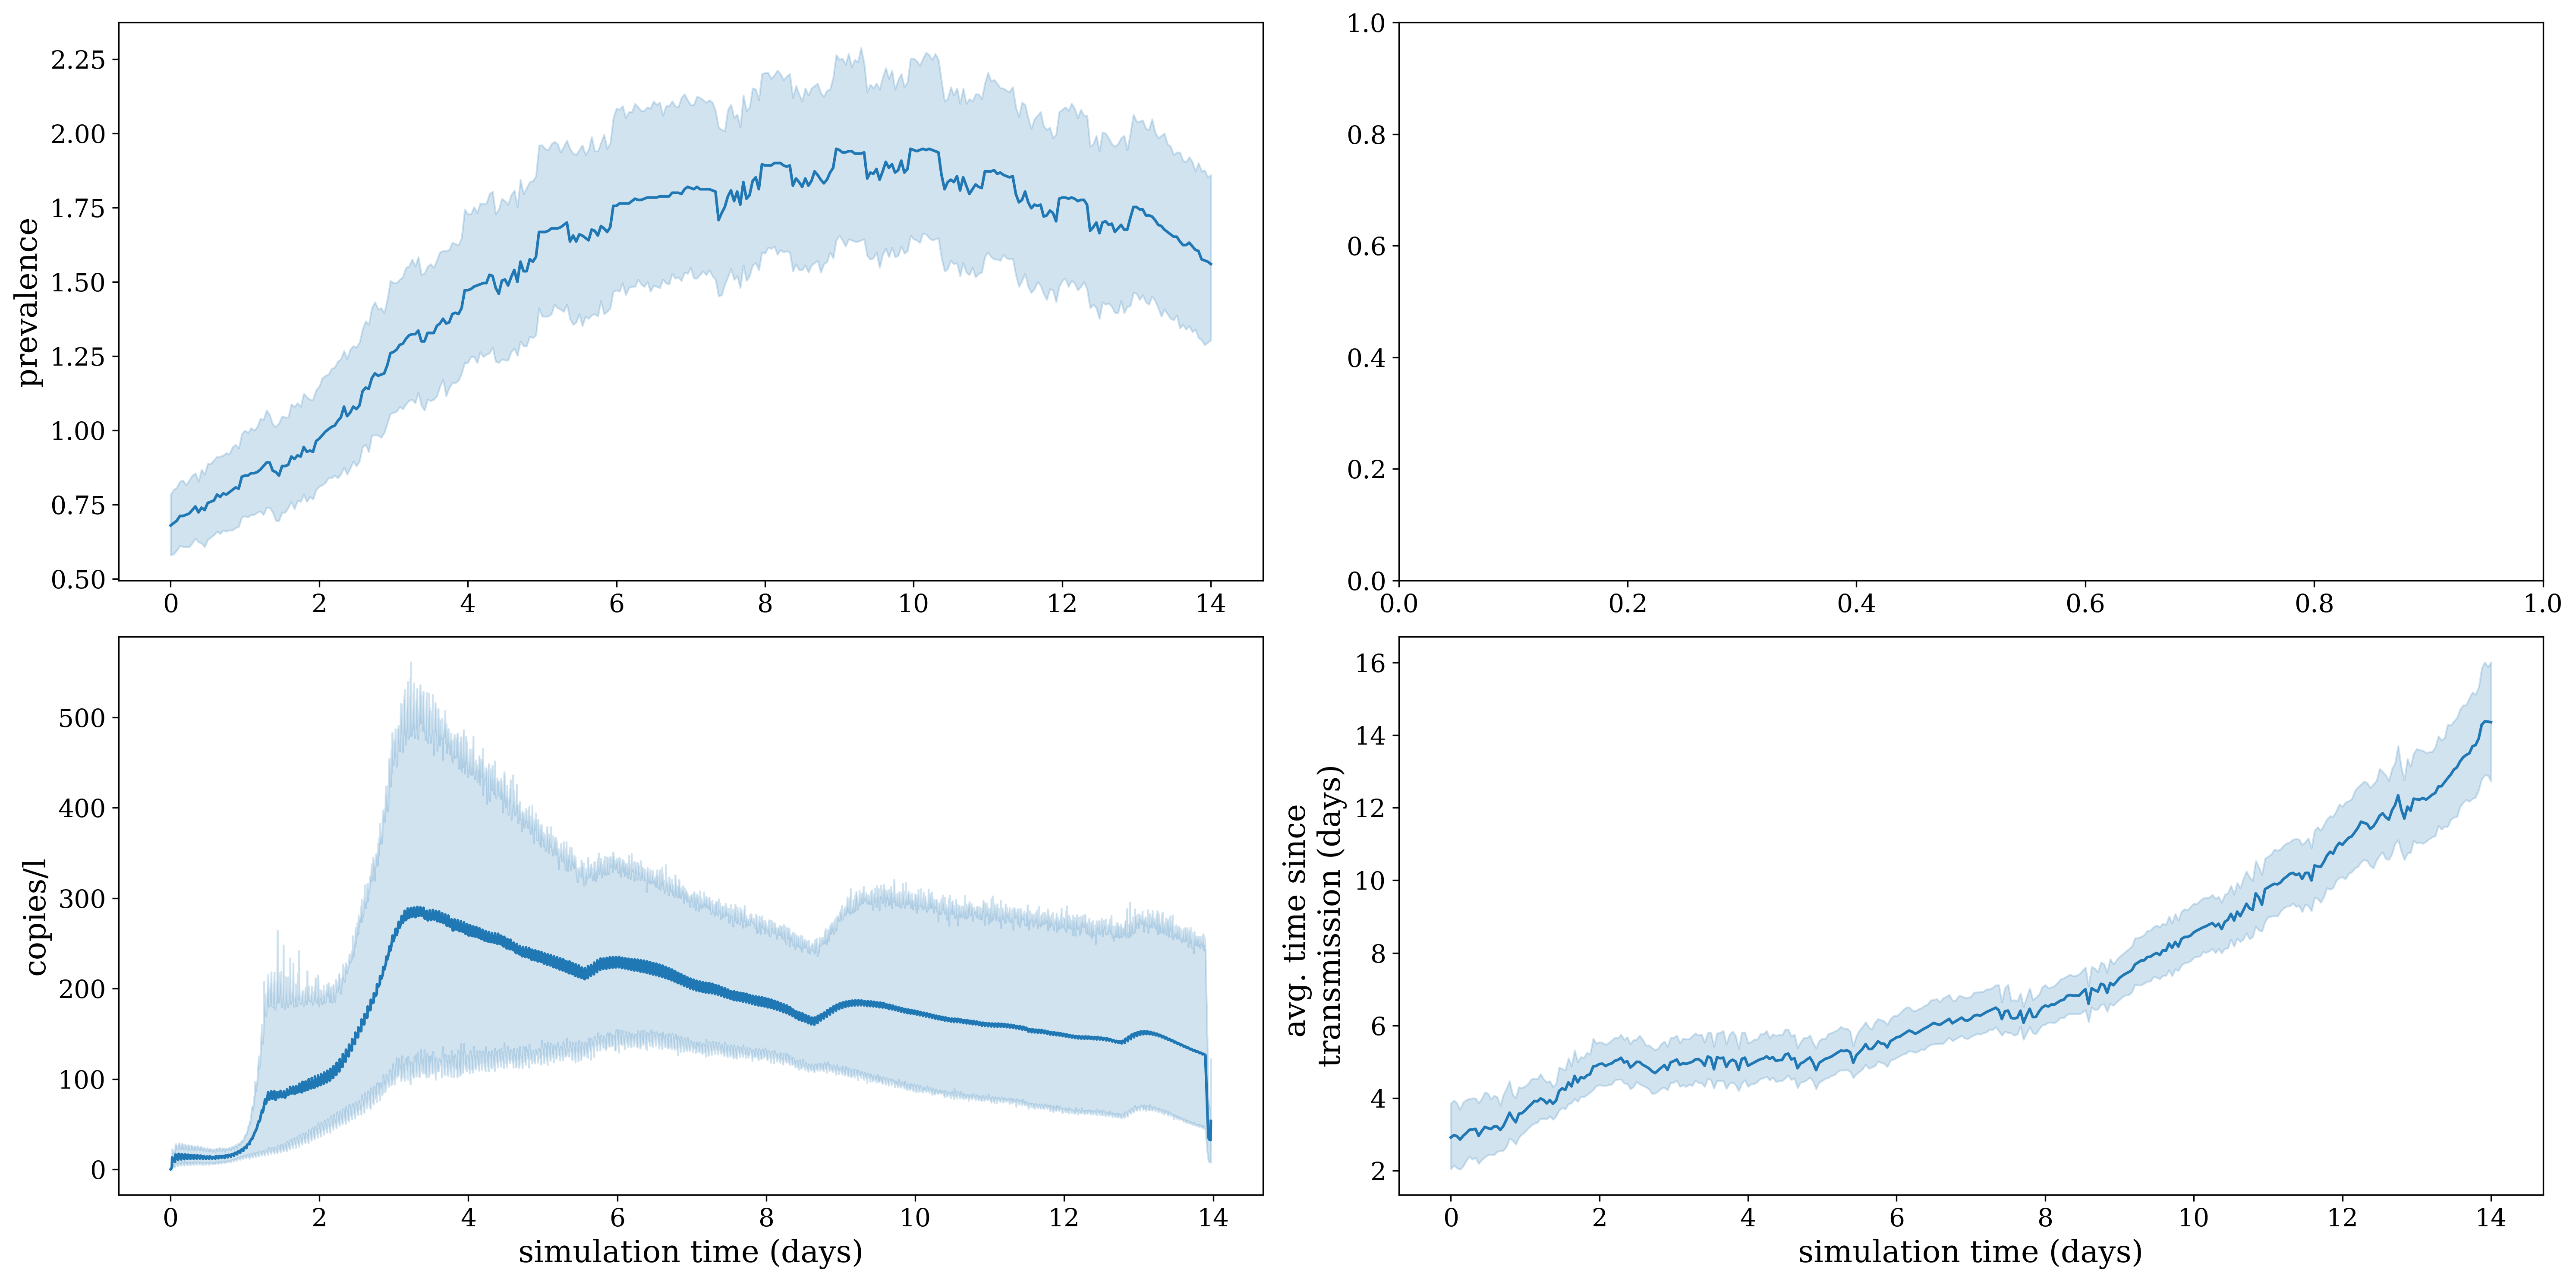

In [47]:
sampling_location = "1"
upstream_locations = upstream_locations_dict[sampling_location]
df_conc_sub = df_conc.loc[(df_conc.sampling_point==sampling_location), :].copy()

upstream_infections = df_infections_total.loc[df_infections_total.systems_location.isin(upstream_locations)].copy()
# For each simulation id and location we have the average time since transmission.
# We now want to calculate the average over several locations -> 1. calculate total -> 2. calculate average with new grouping information
upstream_infections.loc[:,"total_times_since_transmission"] = upstream_infections.loc[:,"n_agents"]*upstream_infections.loc[:,"avg_times_since_transmission"]
upstream_infections = upstream_infections.groupby(["time_in_days", "simulation_id"]).sum().reset_index()[["simulation_id", "time_in_days", "n_infections", "n_agents", "total_times_since_transmission"]]
upstream_infections.loc[:,"avg_times_since_transmission"] = upstream_infections.loc[:,"total_times_since_transmission"]/upstream_infections.loc[:,"n_infections"]

date_form = DateFormatter("%-d")

fig, axs = plt.subplots(nrows=2, ncols=2, sharey=False, sharex=False, figsize=(20,10), dpi=300)

# first column
upstream_infections["prevalence"] = upstream_infections["n_infections"]# /upstream_infections["n_agents"]
sns.lineplot(upstream_infections, x="time_in_days", y="prevalence", ax=axs[0,0])
axs[0,0].set_ylabel("prevalence [#]", fontsize=17)
axs[0,0].set_xlabel("", fontsize=17)

sns.lineplot(data=df_conc_sub, x="time", y="copies/l", ax=axs[1,0])
axs[1,0].xaxis.set_major_formatter(date_form) 
axs[1,0].set_xlabel(f"simulation time [days]", fontsize=17)
axs[1,0].set_ylabel("virus levels [copies/l]", fontsize=17) #  for infected agents
axs[1,0].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])

# second column
sns.lineplot(upstream_infections, x="time_in_days", y="avg_times_since_transmission", ax=axs[1,1])
axs[1,1].set_ylabel("avg. time since \ntransmission [days]", fontsize=17) #  for infected agents
axs[1,1].set_xlabel("simulation time [days]", fontsize=17)


for i in range(2):
    for j in range(2):
        axs[i,j].tick_params(axis='x', labelsize=14)
        axs[i,j].tick_params(axis='y', labelsize=14)

plt.tight_layout()
plt.savefig(os.path.join(plot_path, file_name_prefix+f'_aggregated_overview_{sampling_location}.png'))